# Cell-Cell interaction Analysis using NCEM  
### Spatial pancreas  
Subset of a non-diabetic slide (fov == 12) 

### Pre-requisites

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

import scanpy as sc
import squidpy as sq
import ncem as nc

import matplotlib.pyplot as plt

sc.settings.set_figure_params(dpi=80, facecolor="white")

2024-07-04 08:19:33.484288: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-04 08:19:33.614925: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-04 08:19:36.127783: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-04 08:19:40.917087: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 08:20:04.876396: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
nc.__version__

'0.1.5'

### Load data

In [3]:
adata_s1 = sc.read('../../../../../../datasets/projects/20230301_Sander_SpatialPancreas_sara.jimenez/spatial/S1_annotated_l0.h5ad')
adata_s1

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 108711 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [4]:
adata = adata_s1[np.isin(adata_s1.obs['fov'],['10'])].copy()
adata

AnnData object with n_obs × n_vars = 4423 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [6]:
adata.obs['cell_type_coarse'].cat.categories

Index(['Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial',
       'Fibroblasts', 'Immune', 'Mast'],
      dtype='object')

In [8]:
adata.uns['cell_type_coarse_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
    '#582f0e'  #mast
]

### Data Exploration

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


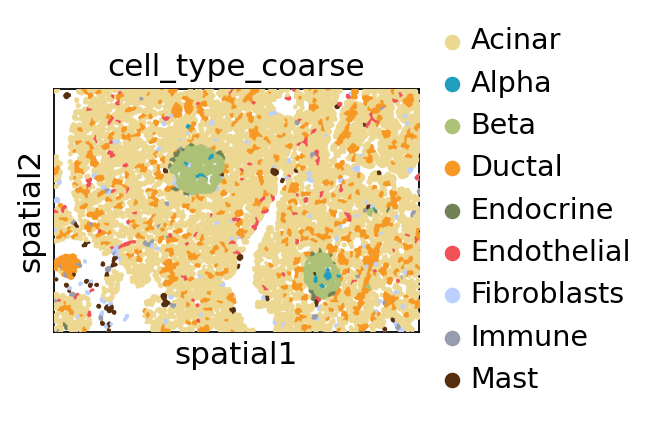

In [9]:
sq.pl.spatial_segment(adata,color='cell_type_coarse',ncols=2,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [10]:
from matplotlib.pyplot import rc_context

In [11]:
HORMONES = ['INS','GCG','SST']
#adata.uns['cell_type_coarse_colors'] = ['#00bbf9', '#a7c957', '#F4BA41', '#e63946', '#6c757d', '#ffcdb2','#fb8500']

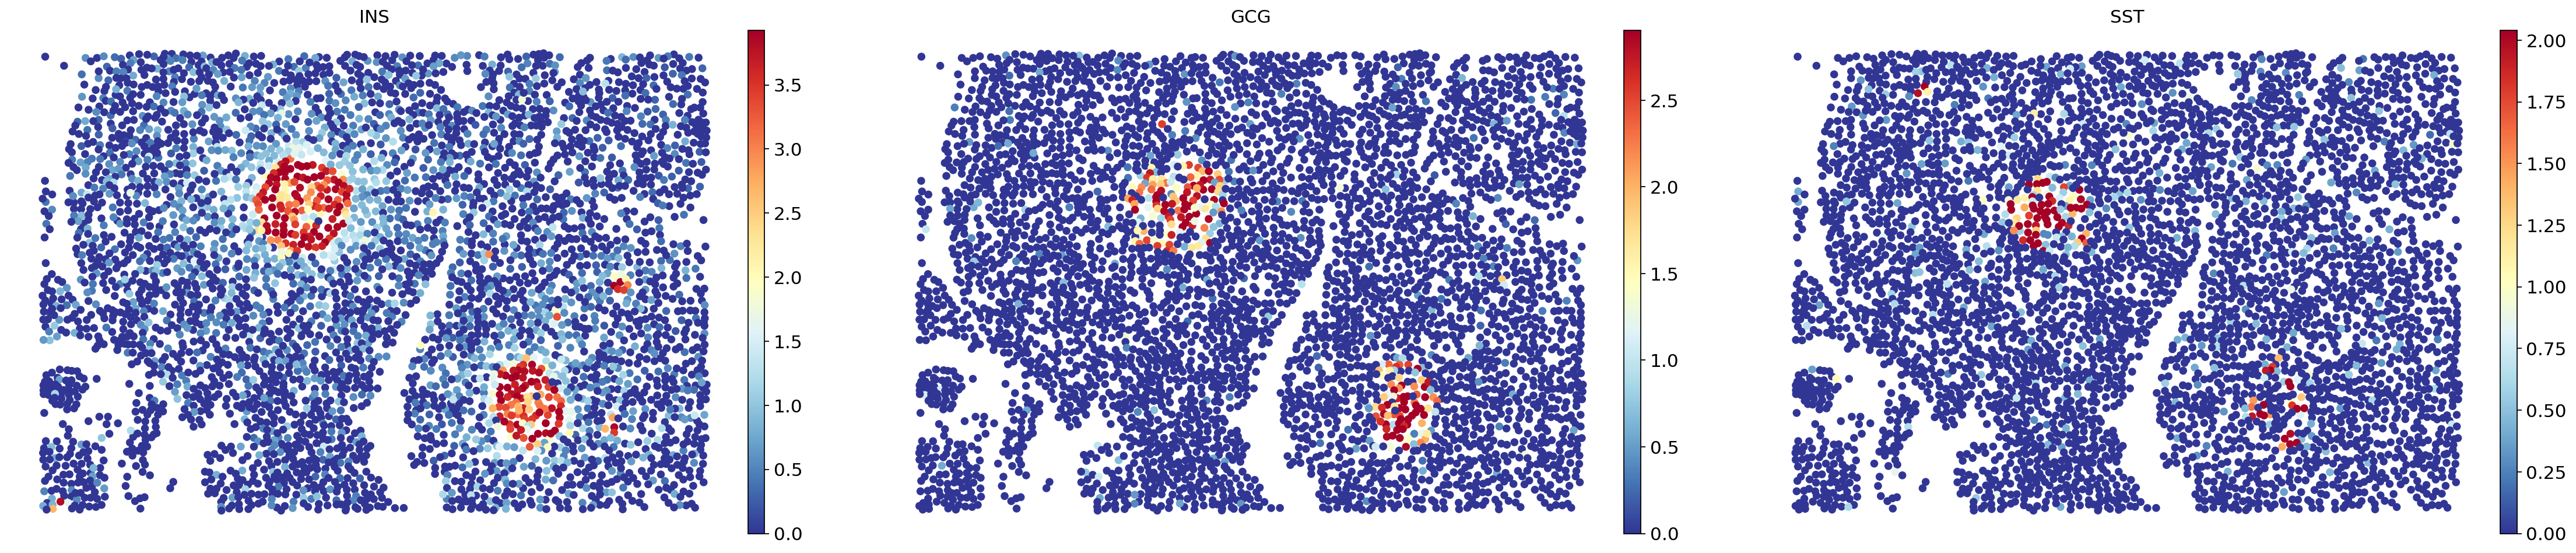

In [12]:
# Check expression of known markers to get intuition of the dataset
with rc_context({'figure.figsize': (10.5,7)}):
    sc.pl.embedding(
        adata,
        basis='spatial',
        color=HORMONES,
        vmin=0,
        vmax='p99',  
        sort_order=False,  
        frameon=False,
        cmap='RdYlBu_r', 
        size=150,ncols=3
    )

In [13]:
type(adata.X)

scipy.sparse._csr.csr_matrix

In [14]:
adata.X = adata.X.toarray()

1. Noise distribution of the dataset per cell type 
- NCEM requires gaussian distribution not negative binomial 
- Important not to overnormalized -> the 

Acinar
Alpha
Beta
Ductal
Endocrine
Endothelial
Fibroblasts
Immune
Mast


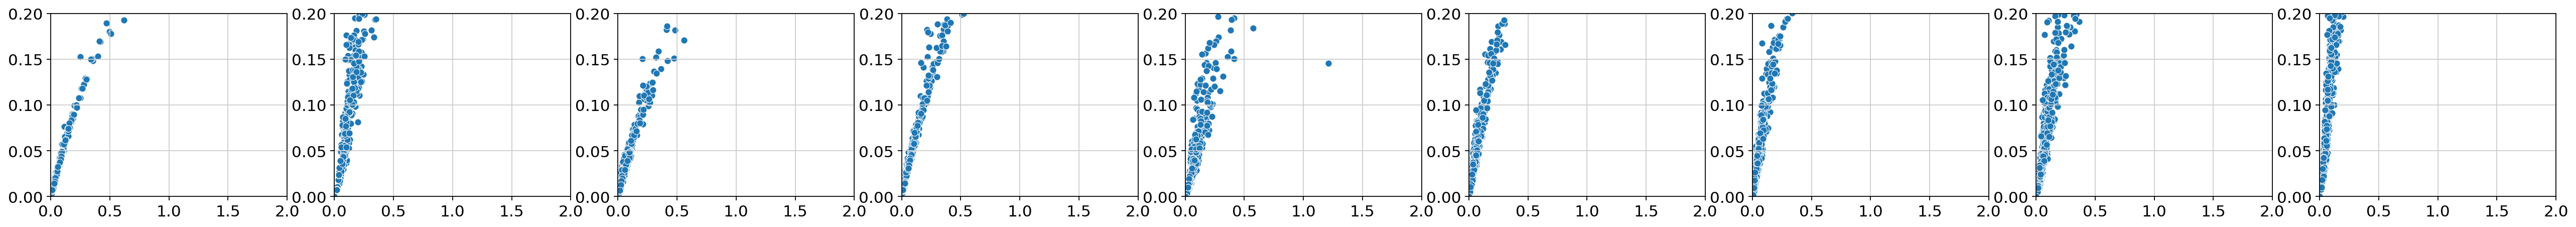

In [15]:
fig, ax = plt.subplots(1,len(np.unique(adata.obs['cell_type_coarse'])), figsize=(40,3))
for i, ct in enumerate(np.unique(adata.obs['cell_type_coarse'])):
    print(ct)
    mean = np.mean(adata[adata.obs['cell_type_coarse']==ct].X, axis=0)
    var = np.var(adata[adata.obs['cell_type_coarse']==ct].X, axis=0)
    g=sns.scatterplot(x=mean, y=var, ax=ax[i])
    g.set(ylim=(0, 0.2), xlim=(0,2))

In [17]:
adata.obs['cell_type_coarse'].cat.categories

Index(['Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial',
       'Fibroblasts', 'Immune', 'Mast'],
      dtype='object')

### Pre-processing

In [18]:
adata.X.max()

4.3824596

In [19]:
adata.layers['counts'].max()

226

#### the data seems normalized
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
adata.X

In [20]:
# calculating node degree for several distances 
for rd in [0,35,50,110,180,500]:
    connectivities, _ = sq.gr.spatial_neighbors(
        adata, radius=rd, coord_type='generic', copy=True
    )
    print(np.mean(np.sum(connectivities, axis=0)))

0.0
0.15238525887406737
0.9509382771874293
8.533574496947773
23.224960434094506
166.51232195342527


In [27]:
sq.gr.spatial_neighbors(
    adata,
    n_neighs=50,
    coord_type="generic",
    delaunay=True,
)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_color_utils.py:27: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


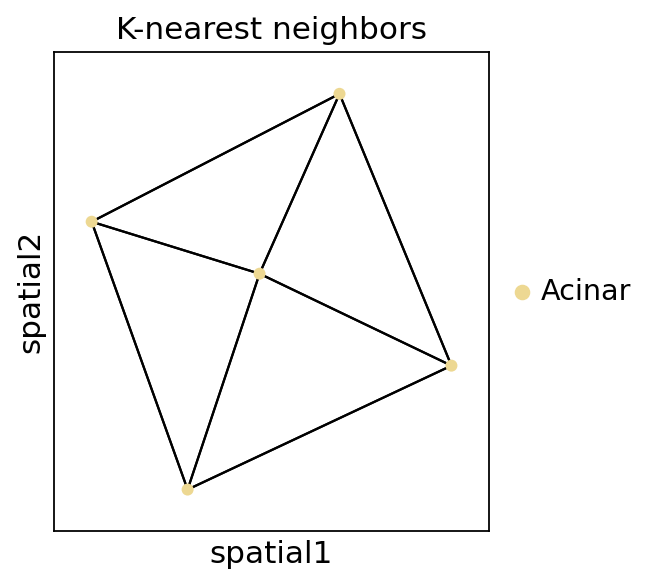

In [28]:
_, idx = adata.obsp["spatial_connectivities"][420, :].nonzero()
idx = np.append(idx, 420)
sq.pl.spatial_scatter(
    adata[idx,420],
    library_id = '10',
    color="cell_type_coarse",
    connectivity_key="spatial_connectivities",
    size=3,
    edges_width=1,
    edges_color="black",
    img=False,
    title="K-nearest neighbors"
)

### Neighbors enrichment analysis

In [29]:
sq.gr.nhood_enrichment(adata,cluster_key='cell_type_coarse')

100%|██████████| 1000/1000 [00:00<00:00, 2384.06/s]


/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


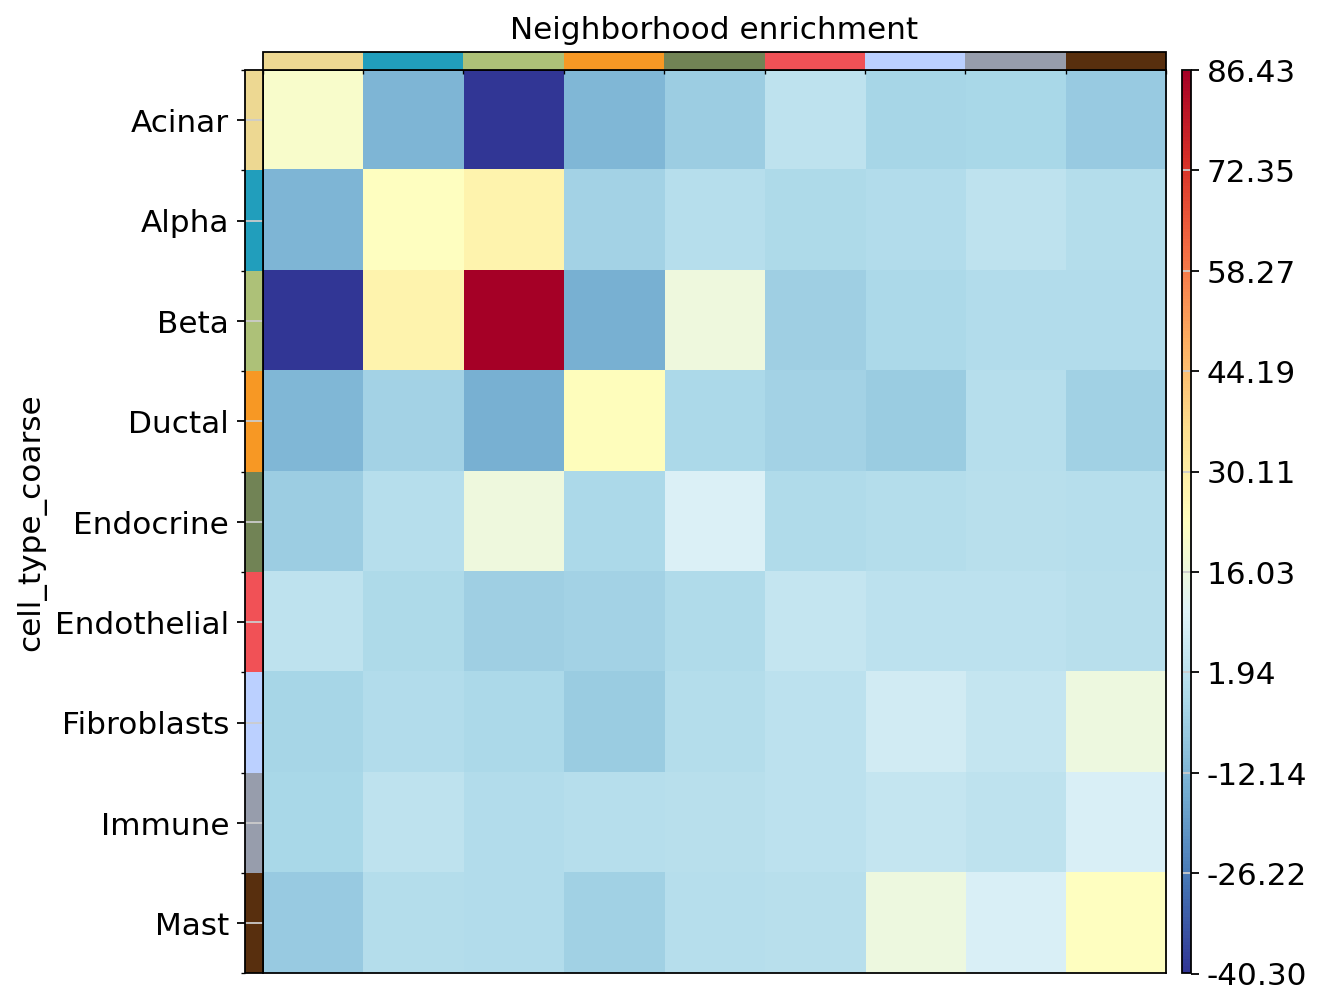

In [30]:
sq.pl.nhood_enrichment(adata, cluster_key='cell_type_coarse',cmap='RdYlBu_r')

In [32]:
sq.gr.interaction_matrix(adata, cluster_key='cell_type_coarse',weights=True)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


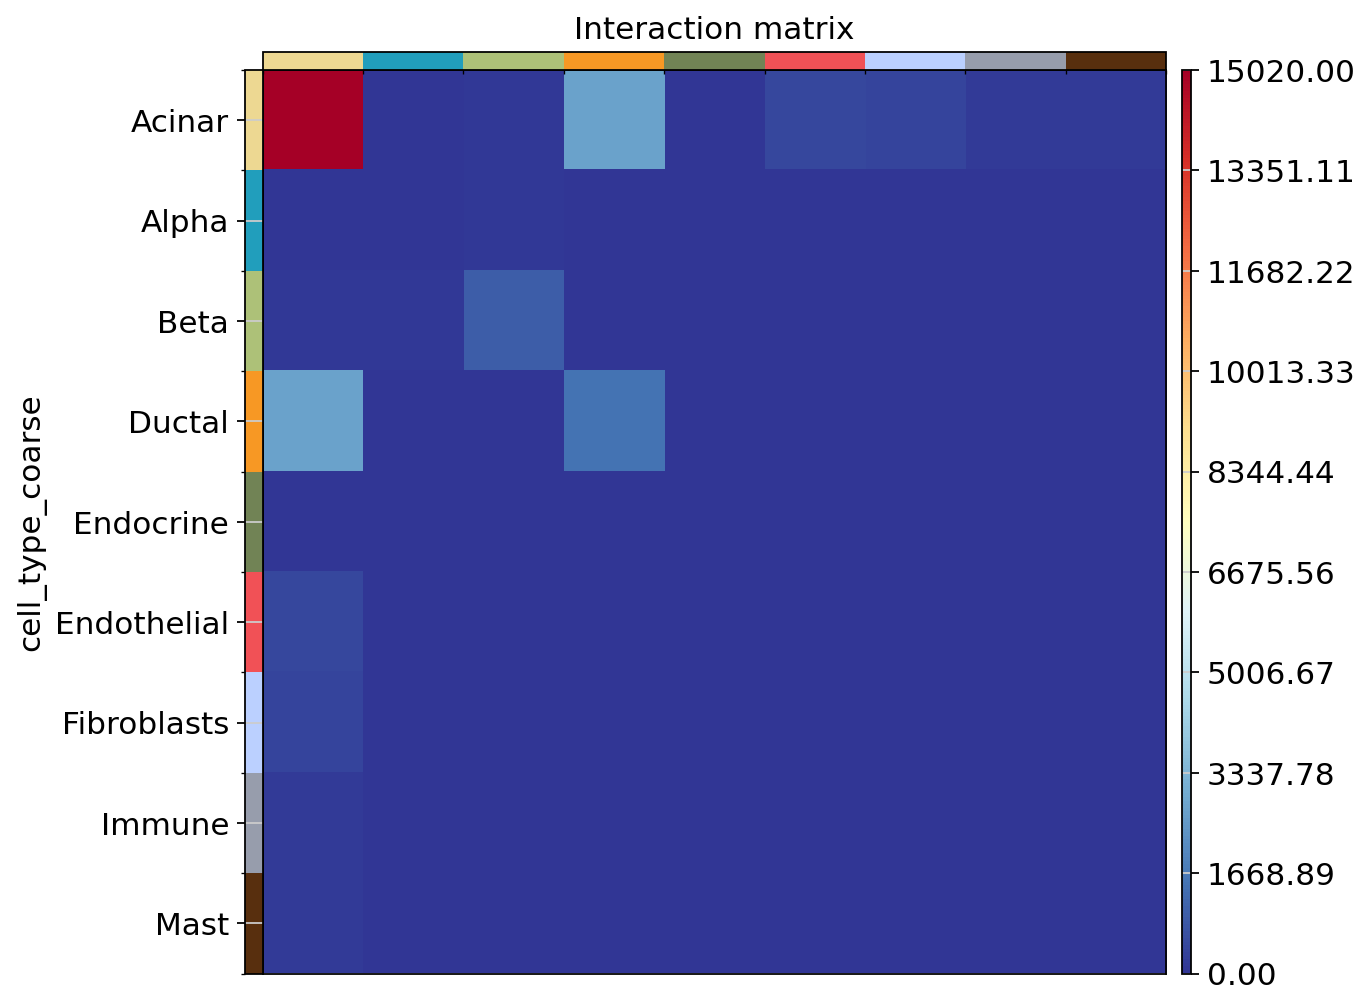

In [33]:
sq.pl.interaction_matrix(adata, cluster_key='cell_type_coarse',cmap='RdYlBu_r')

### Compute Ripley’s statistics
The Ripley’s L function is a descriptive statistics generally used to determine whether points have a random, dispersed or clustered distribution pattern at certain scale.

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/home/aih/sara.jimenez/miniconda3/envs/ncem/l

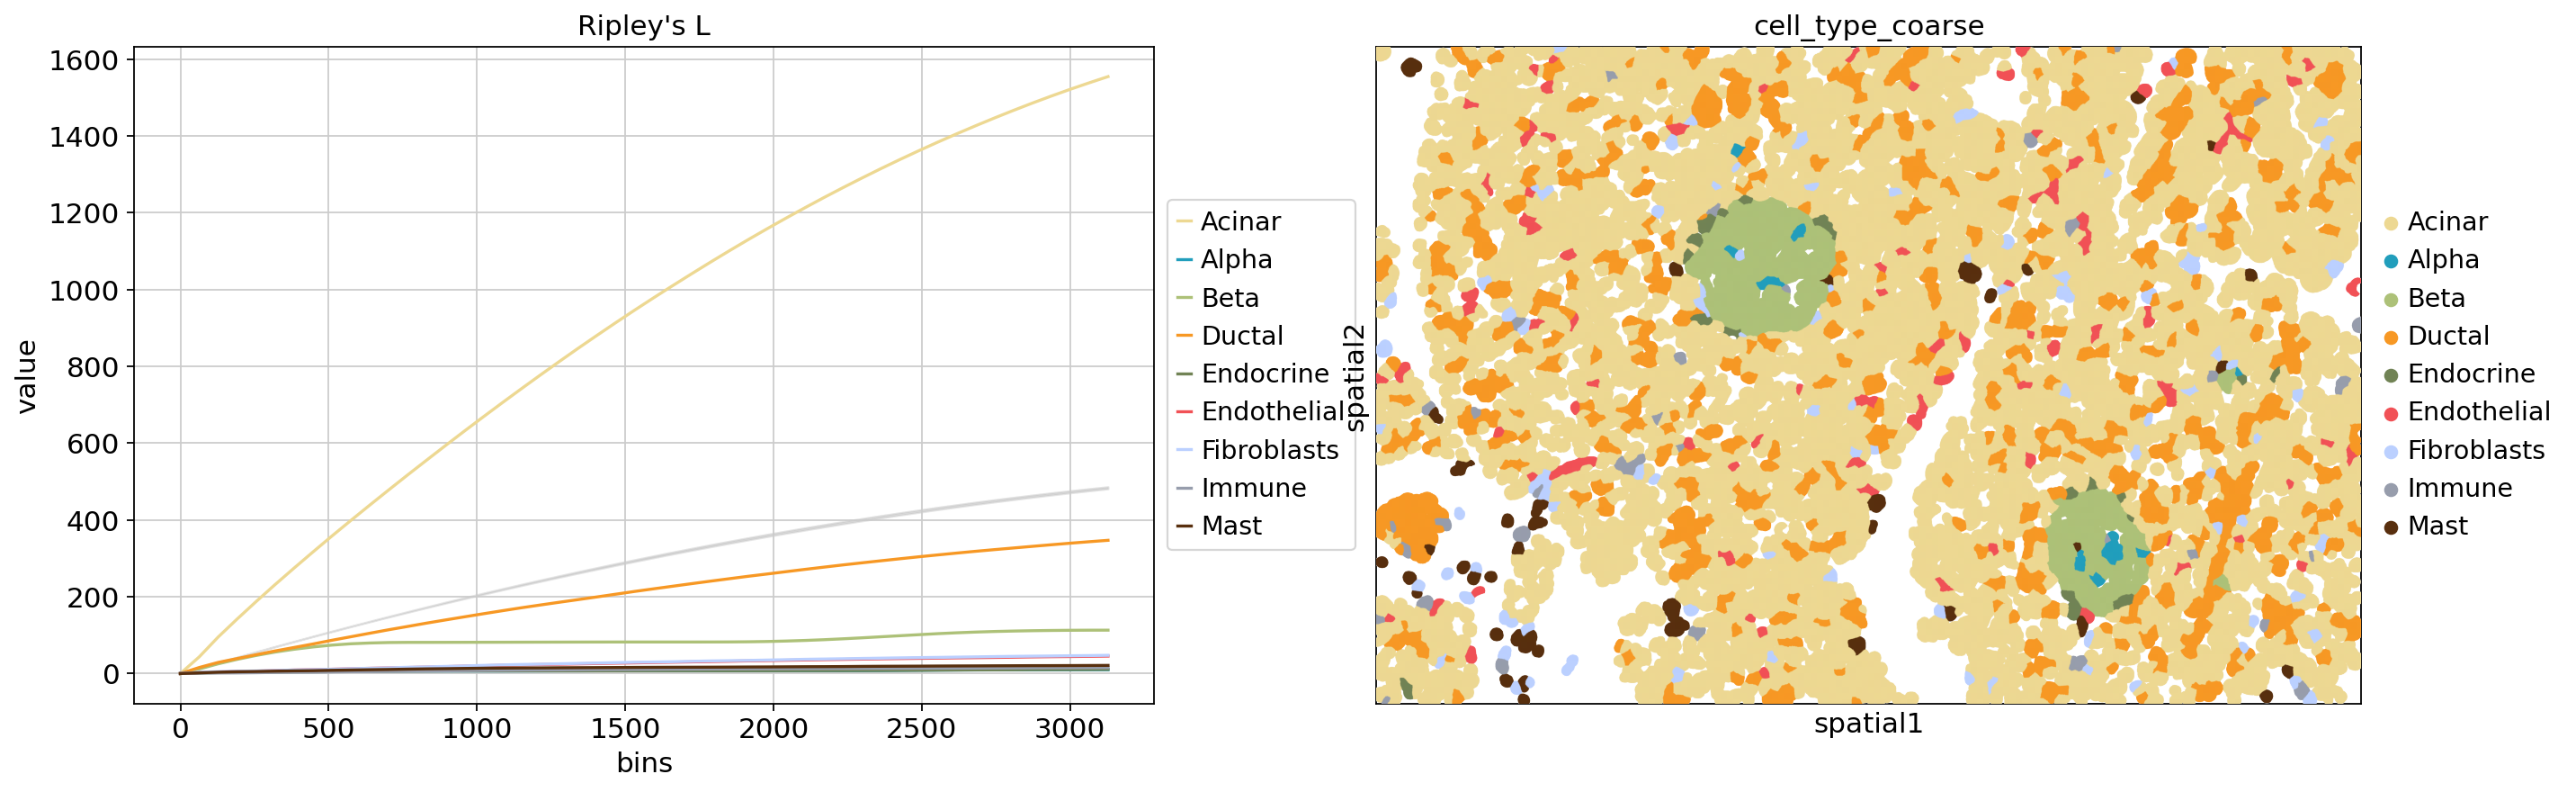

In [34]:
mode = "L"
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sq.gr.ripley(adata, cluster_key="cell_type_coarse", mode=mode)
sq.pl.ripley(
    adata,
    cluster_key="cell_type_coarse",
    mode=mode,
    ax=ax[0],
)

sq.pl.spatial_segment(
    adata,
    shape="hex",
    color="cell_type_coarse",
    library_id="10",
    library_key="fov",
    seg_cell_id="cell_ID",
    img=False,
    size=60,
    ax=ax[1],
)

### Moran’s I score

The Moran’s I global spatial auto-correlation statistics evaluates whether features (i.e. genes) shows a pattern that is clustered, dispersed or random in the tissue are under consideration.

In [35]:
#sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)
adata.uns["moranI"].head(10)

100%|██████████| 100/100 [00:19<00:00,  5.16/s]


I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
INS     0.760236        0.0  0.000077         0.0  0.009901  0.000182   
TTR     0.690693        0.0  0.000077         0.0  0.009901  0.000153   
GCG     0.672162        0.0  0.000077         0.0  0.009901  0.000180   
PRSS2   0.630984        0.0  0.000077         0.0  0.009901  0.000128   
CHGA    0.624503        0.0  0.000077         0.0  0.009901  0.000141   
REG1A   0.603012        0.0  0.000077         0.0  0.009901  0.000122   
CPB1    0.577031        0.0  0.000077         0.0  0.009901  0.000113   
IAPP    0.543026        0.0  0.000077         0.0  0.009901  0.000114   
SST     0.498951        0.0  0.000077         0.0  0.009901  0.000112   
SPINK1  0.458825        0.0  0.000077         0.0  0.009901  0.000105   

        pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
INS                  0.0                0.0         0.039243  
TTR                  0.0                0.0         0.039243  
GCG                  0.0                0.0         0.039243  
PRSS2                0.0                0.0         0.039243  
CHGA                 0.0                0.0         0.039243  
REG1A                0.0                0.0         0.039243  
CPB1                 0.0                0.0         0.039243  
IAPP                 0.0                0.0         0.039243  
SST                  0.0                0.0         0.039243  
SPINK1               0.0                0.0         0.039243

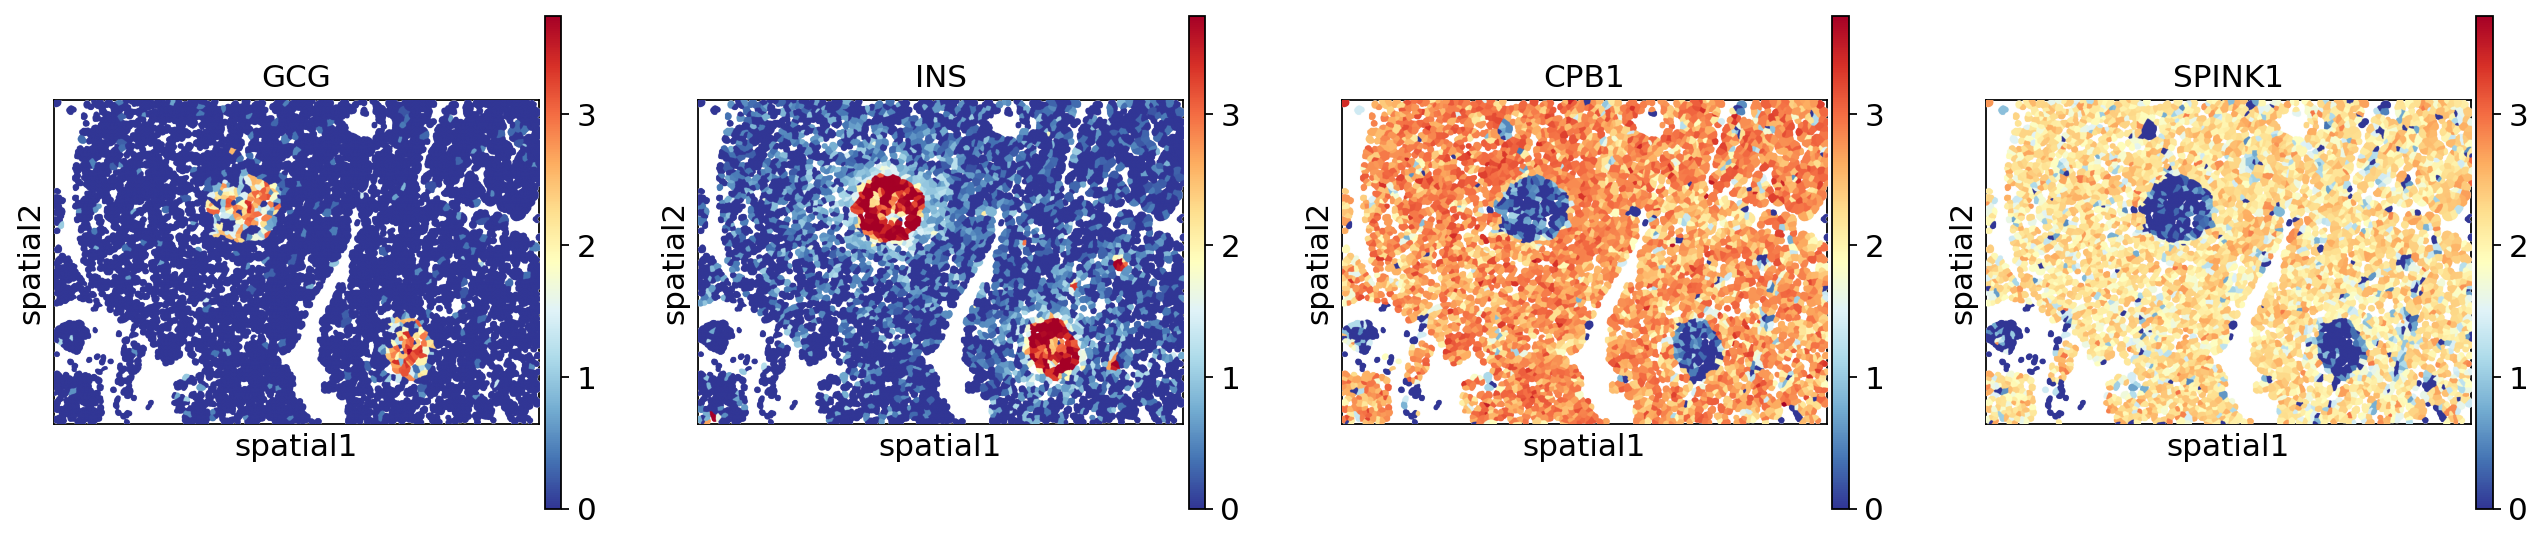

In [36]:
sq.pl.spatial_segment(
    adata,
    library_id="10",
    seg_cell_id="cell_ID",
    library_key="fov",
    color=["GCG", "INS", "CPB1","SPINK1"],
    size=60,
    img=False,cmap="RdYlBu_r"
)

### Ligand receptor analysis

In [37]:
sq.gr.ligrec(adata,cluster_key='cell_type_coarse',use_raw=False, alpha=0.005)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  File "/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/urllib3/connectionpool.py", line 715, in urlopen
    httplib_response = self._make_request(
  File "/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/urllib3/connectionpool.py", line 404, in _make_request
    self._validate_conn(conn)
  File "/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/urllib3/connectionpool.py", line 1058, in _validate_conn
    conn.connect()
  File "/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/urllib3/connection.py", line 419, in connect
    self.sock = ssl_wrap_socket(
  File "/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-p

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_ligrec.py:306: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for cls, size in (pvals.groupby(level=0, axis=1)).size().to_dict().items():
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:121: UserWarning: Over 500 categories found. Plot would be very large.
  warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


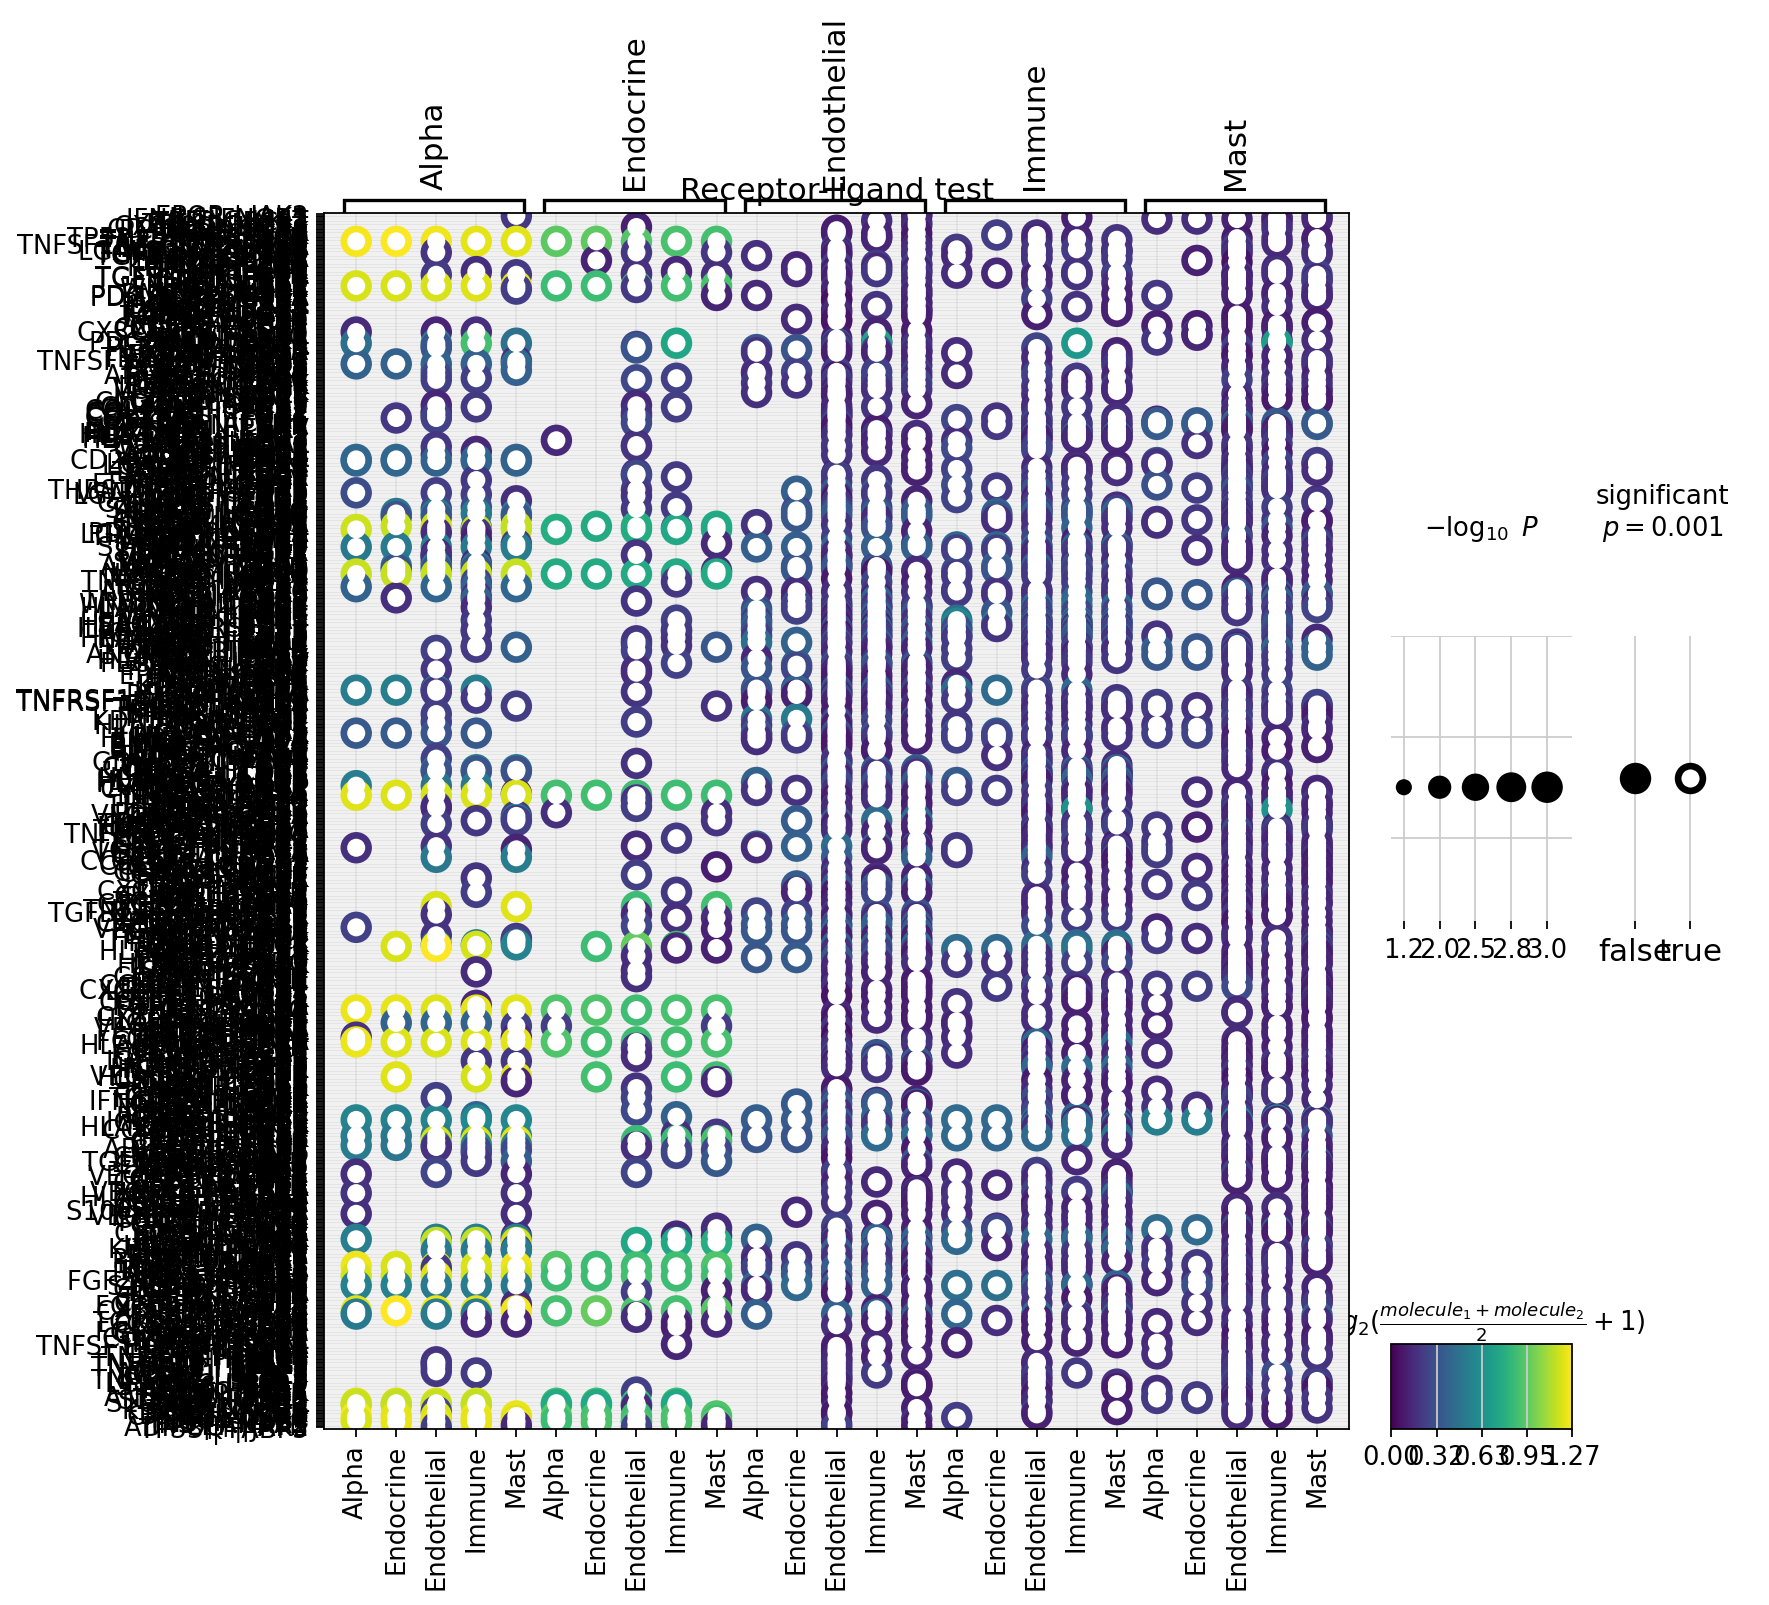

In [38]:
sq.pl.ligrec(adata, cluster_key='cell_type_coarse',pvalue_threshold=0.0001,
             remove_nonsig_interactions=True, remove_empty_interactions=True,figsize = (10,10))

### NCEM

In [39]:
from ncem.tl.fit.glm import linear_ncem

In [ ]:
linear_ncem

In [40]:
adata = linear_ncem(adata=adata, key_type='cell_type_coarse', key_graph='spatial_connectivities')

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [41]:
adata.obs['cell_type_coarse'].cat.categories

Index(['Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial',
       'Fibroblasts', 'Immune', 'Mast'],
      dtype='object')

In [42]:
adata

AnnData object with n_obs × n_vars = 4423 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'cell_type_coarse_colors', 'spatial_neighbors', 'cell_type_coarse_nhood_enrichment', 'cell_type_coarse_interactions', 'cell_type_coarse_ripley_L', 'moranI', 'cell_type_coarse_ligrec', 'nce

#### Exploring interesting interactions

In [43]:
adata.varm['ncem_params']

index_Acinar   index_Alpha  index_Beta  index_Ductal  \
AATK          0.011885  3.131751e-01    0.009409      0.064997   
ABL1         -0.012899  6.774066e-02    0.066926      0.053196   
ABL2          0.356560  1.877023e-01   -0.014503      0.079181   
ACE           0.000474  2.596726e-15    0.009338      0.062562   
ACE2         -0.002646  5.111413e-15    0.050391     -0.005865   
...                ...           ...         ...           ...   
NegPrb19     -0.005339  3.421822e-15    0.448450      0.011386   
NegPrb20      0.001090  5.530273e-15   -0.039341      0.011630   
NegPrb21     -0.009146  3.238329e-16    0.003387      0.002415   
NegPrb22      0.000417  1.026915e-02   -0.000755      0.013070   
NegPrb23      0.002707 -4.735350e-15   -0.010204      0.004908   

          index_Endocrine  index_Endothelial  index_Fibroblasts  index_Immune  \
AATK        -2.009691e-02       5.172445e-02      -3.352253e-02 -1.141361e-02   
ABL1        -7.324458e-16       2.897628e-03       2.202596e-01 -1.675604e-02   
ABL2        -1.578744e-02      -1.429143e-02       5.978749e-02  9.015285e-02   
ACE          2.743709e-02       1.557387e-02       4.234091e-03 -4.024667e-15   
ACE2        -1.142720e-02       5.064354e-02       1.197349e-01  4.813945e-01   
...                   ...                ...                ...           ...   
NegPrb19     8.049967e-15      -6.282670e-15      -9.079993e-16 -1.134938e-02   
NegPrb20    -2.459375e-02      -4.579356e-02       3.957965e-02  5.659445e-02   
NegPrb21     1.599977e-02      -3.242638e-02      -4.580967e-02 -2.091392e-15   
NegPrb22    -2.622116e-15       2.612893e-02       6.071405e-03 -6.724320e-02   
NegPrb23    -9.309692e-15      -7.881253e-03       3.123908e-02 -1.438434e-01   

            index_Mast  index_Acinar:neighbor_Acinar  ...  \
AATK      2.042354e-01                      0.032667  ...   
ABL1      6.396521e-02                      0.042332  ...   
ABL2      1.166679e-01                     -0.170412  ...   
ACE      -1.530790e-01                      0.010574  ...   
ACE2      4.844419e-15                      0.017547  ...   
...                ...                           ...  ...   
NegPrb19  2.236563e-15                      0.024880  ...   
NegPrb20  1.158073e-01                      0.034173  ...   
NegPrb21  2.458076e-01                      0.022564  ...   
NegPrb22  5.167676e-15                      0.026809  ...   
NegPrb23  5.530621e-01                      0.009809  ...   

          index_Mast:neighbor_Immune  index_Acinar:neighbor_Mast  \
AATK                   -3.443665e-02                    0.000631   
ABL1                   -1.056858e-01                   -0.007361   
ABL2                   -3.627722e-02                   -0.029345   
ACE                    -3.293853e-02                   -0.006328   
ACE2                   -1.912409e-16                    0.000929   
...                              ...                         ...   
NegPrb19               -2.918764e-16                   -0.002931   
NegPrb20               -9.278262e-03                    0.011295   
NegPrb21                7.258155e-03                   -0.012610   
NegPrb22               -3.257649e-16                   -0.008916   
NegPrb23               -2.051630e-01                    0.022967   

          index_Alpha:neighbor_Mast  index_Beta:neighbor_Mast  \
AATK                  -1.214920e-01                 -0.093613   
ABL1                  -2.483824e-01                  0.007084   
ABL2                   1.691676e+00                 -0.010442   
ACE                    5.100706e-16                 -0.055508   
ACE2                   2.680127e-15                  0.029974   
...                             ...                       ...   
NegPrb19               1.295289e-15                 -0.011805   
NegPrb20               7.924876e-16                  0.013862   
NegPrb21               4.073509e-16                 -0.016421   
NegPrb22              -3.765354e-02         

In [49]:
#df = pd.DataFrame(np.sum(np.absolute(adata.varm['ncem_fdr_pvals']<0.05)))
df = pd.DataFrame(np.sum(np.absolute(adata.varm['ncem_params'])))
df_int = pd.DataFrame(columns=adata.obs['cell_type_coarse'].cat.categories, index=adata.obs['cell_type_coarse'].cat.categories,dtype=float)
for s in adata.obs['cell_type_coarse'].cat.categories:
    for r in adata.obs['cell_type_coarse'].cat.categories: 
        index_value = 'index_'+s+':neighbor_'+r
        df_int.at[s,r] = df.loc[index_value][0]
df_int

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Acinar         Alpha        Beta     Ductal   Endocrine  \
Acinar        64.900219  3.693279e+01   19.248487   4.508627   17.853874   
Alpha         54.684806  7.942502e+01  119.451223  50.448278   73.541814   
Beta          23.716147  2.514390e+01   93.735734  31.259678   23.695453   
Ductal        46.590782  6.131564e+01   36.383787  21.698898   43.213601   
Endocrine     45.313947  9.397925e+01   70.192773  53.045719   53.518604   
Endothelial   47.930956  1.858502e-12   54.347834  30.363299   54.347834   
Fibroblasts   76.738389  1.169151e+02   78.724405  35.651365  109.443258   
Immune       130.549425  2.700709e+02  119.562321  68.007691  165.444464   
Mast          71.127842  1.993786e+02  116.940336  67.197018  130.484577   

              Endothelial  Fibroblasts     Immune        Mast  
Acinar       6.199783e+00     6.841845  11.613243   11.808997  
Alpha        4.571108e-13    82.538268  77.844083   92.417975  
Beta         7.470698e+01    33.296689  38.622282   39.134852  
Ductal       1.906987e+01    24.769718  30.741364   44.389352  
Endocrine    1.256391e+02    71.202188  65.235525  103.479786  
Endothelial  3.050609e+01    44.529283  52.076768   65.008762  
Fibroblasts  3.844922e+01    37.892321  48.129928   45.965127  
Immune       6.537122e+01    63.092392  81.824384   74.248594  
Mast         8.309141e+01    65.835643  62.132729   76.470216

In [45]:
import seaborn as sns

<Axes: >

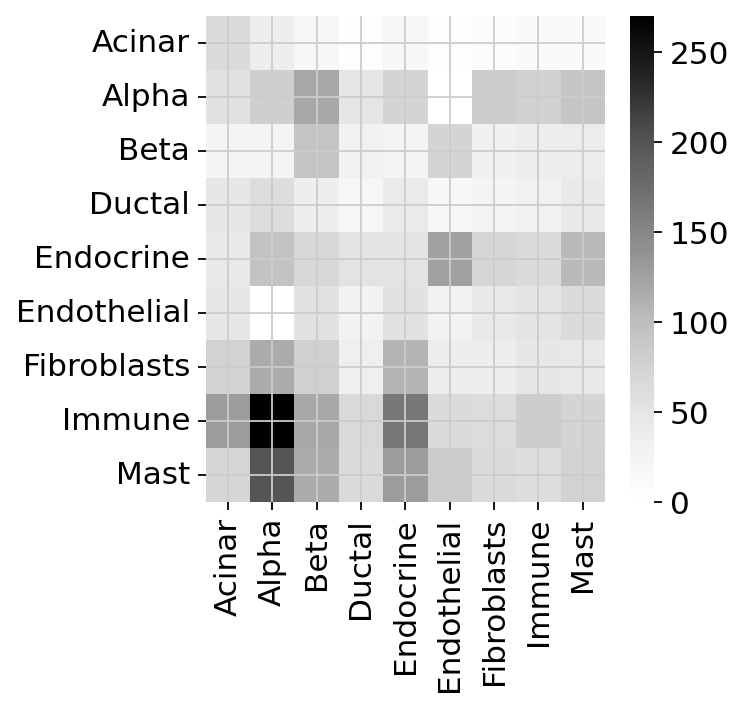

In [51]:
sns.heatmap(
            df_int,
            cmap="Greys",
        )

In [52]:
interactions = [
    'index_Mast:neighbor_Beta',
    'index_Mast:neighbor_Alpha'   
]

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


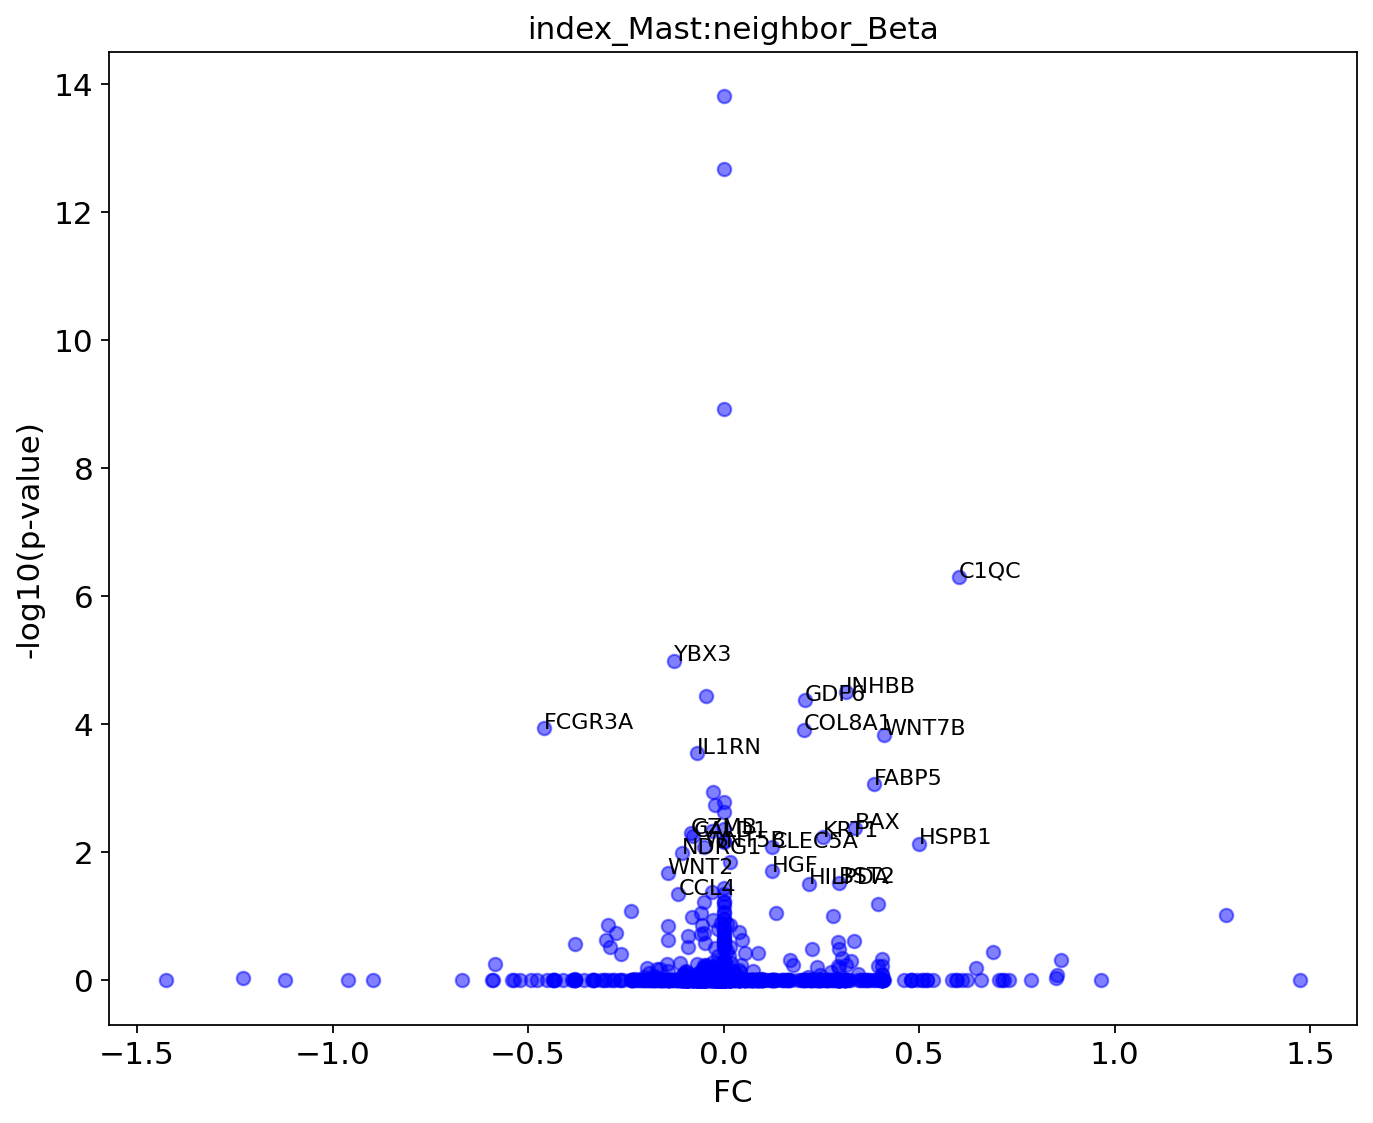

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


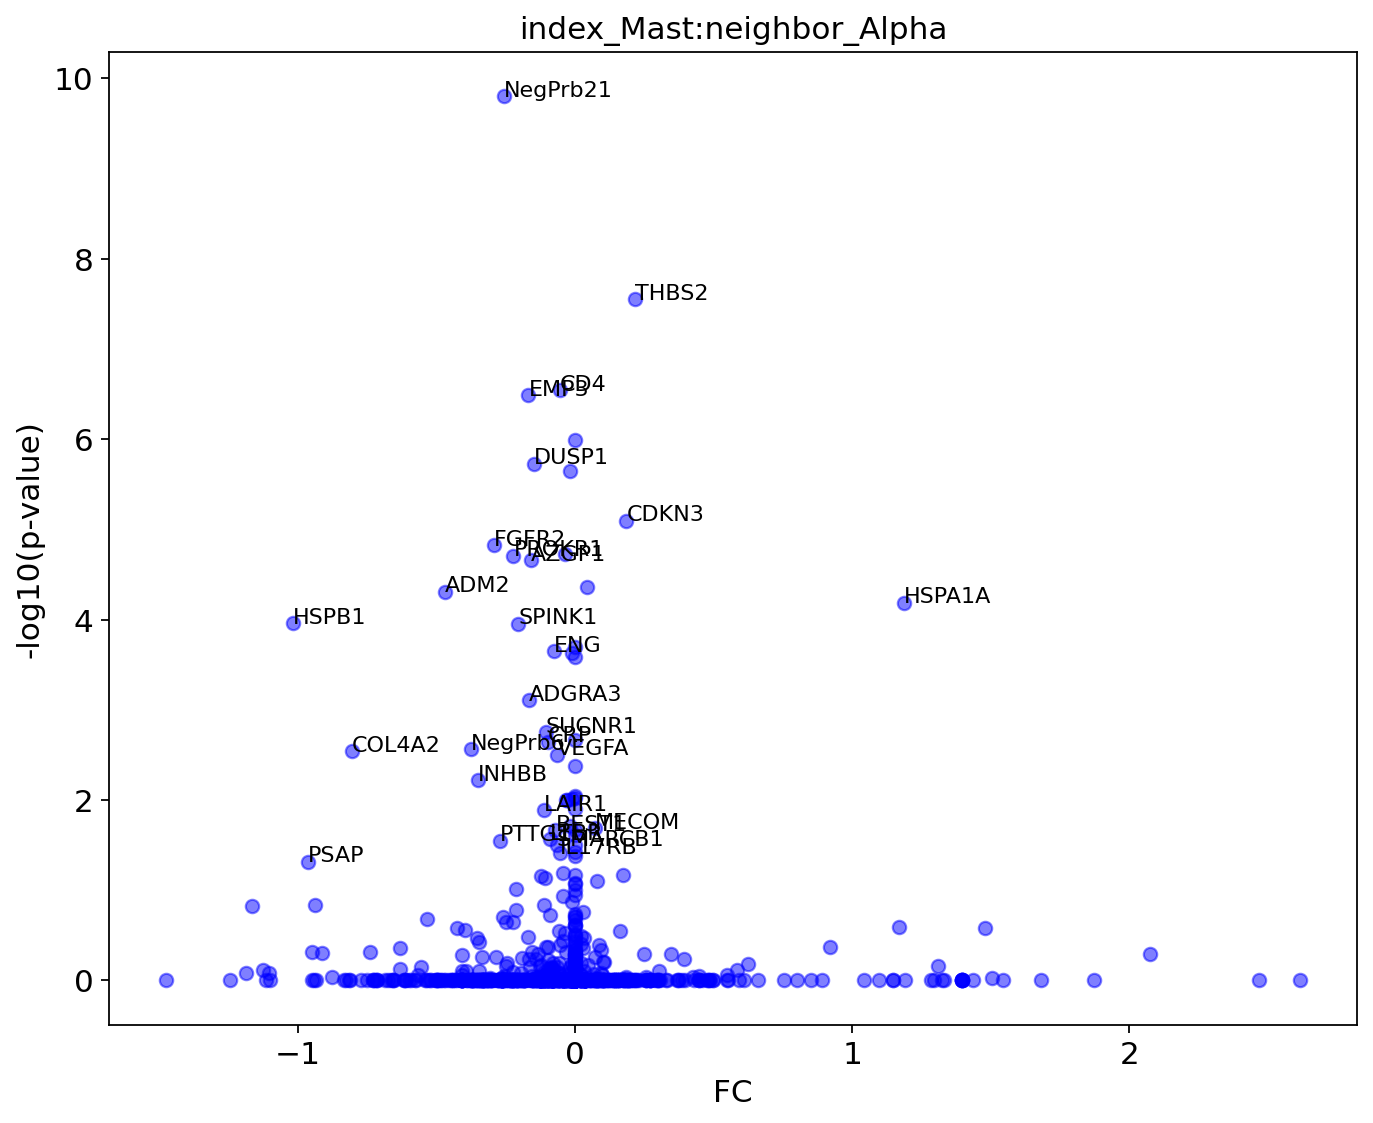

In [53]:
for c in interactions:
    data_df = {
        'log2FoldChange' : adata.varm['ncem_params'][c],
        'padj' : adata.varm['ncem_fdr_pvals'][c],
        'symbol' : np.array(adata.varm['ncem_fdr_pvals'].index)
    }
    
    df = pd.DataFrame(data_df)
    
    df['-log10(p_value)'] = -np.log10(df['padj'])
    

    plt.figure(figsize=(10, 8))
    plt.scatter(df['log2FoldChange'], df['-log10(p_value)'], color='blue', alpha=0.5)
    
    # Label the most significant points
    threshold_logFC = 0.05  # Adjust as needed
    threshold_p_value = 0.05  # Adjust as needed
    significant_points = df[(abs(df['log2FoldChange']) >= threshold_logFC) & (df['padj'] <= threshold_p_value)]
    for i, point in significant_points.iterrows():
        plt.text(point['log2FoldChange'], point['-log10(p_value)'], point['symbol'], fontsize=10)
        #volcano(df)
        
    # Add labels and title
    plt.xlabel('FC')
    plt.ylabel('-log10(p-value)')
    plt.title(c)
    
    # Show plot
    plt.grid(False)
    plt.show()

In [54]:
df

log2FoldChange          padj    symbol  -log10(p_value)
AATK       -1.106429e-01  1.000000e+00      AATK        -0.000000
ABL1       -1.049435e-01  1.000000e+00      ABL1        -0.000000
ABL2       -1.369376e-01  1.000000e+00      ABL2        -0.000000
ACE         7.915914e-02  1.000000e+00       ACE        -0.000000
ACE2       -1.414238e-14  1.000000e+00      ACE2        -0.000000
...                  ...           ...       ...              ...
NegPrb19    1.396051e+00  1.000000e+00  NegPrb19        -0.000000
NegPrb20   -1.871983e-02  7.150135e-01  NegPrb20         0.145686
NegPrb21   -2.549424e-01  1.565416e-10  NegPrb21         9.805370
NegPrb22   -2.213486e-14  1.000000e+00  NegPrb22        -0.000000
NegPrb23   -5.558260e-01  7.111726e-01  NegPrb23         0.148025

[979 rows x 4 columns]

In [55]:
#significant_points = df[(abs(df['log2FoldChange']) >= threshold_logFC) & (df['padj'] <= threshold_p_value)]
significant_points

log2FoldChange          padj     symbol  -log10(p_value)
ADGRA3          -0.165225  7.891279e-04     ADGRA3         3.102853
ADM2            -0.468173  4.900480e-05       ADM2         4.309761
AZGP1           -0.157572  2.200083e-05      AZGP1         4.657561
BEST1           -0.070677  2.163455e-02      BEST1         1.664852
CD4             -0.055840  2.878760e-07        CD4         6.540795
CD63             1.166994  0.000000e+00       CD63              inf
CD68            -0.409131  0.000000e+00       CD68              inf
CD79A           -0.262366  0.000000e+00      CD79A              inf
CD80             0.213442  0.000000e+00       CD80              inf
CD81             1.360324  0.000000e+00       CD81              inf
CD84            -0.394801  0.000000e+00       CD84              inf
CD9             -0.158247  0.000000e+00        CD9              inf
CDKN3            0.185145  8.016383e-06      CDKN3         5.096022
COL4A2          -0.805411  2.862283e-03     COL4A2         2.543287
CRP             -0.098550  2.257738e-03        CRP         2.646326
DUSP1           -0.146638  1.879535e-06      DUSP1         5.725950
EMP3            -0.167802  3.260053e-07       EMP3         6.486775
ENG             -0.074560  2.241494e-04        ENG         3.649462
FGFR2           -0.292154  1.506107e-05      FGFR2         4.822144
HSPA1A           1.185745  6.502841e-05     HSPA1A         4.186897
HSPB1           -1.017275  1.099657e-04      HSPB1         3.958743
IL17RB          -0.055840  3.892967e-02     IL17RB         1.409719
INHBB           -0.349067  6.081653e-03      INHBB         2.215978
ITGB5            0.172296  0.000000e+00      ITGB5              inf
JAG1             0.106763  0.000000e+00       JAG1              inf
JAK1            -0.346378  0.000000e+00       JAK1              inf
JAK2             0.255950  0.000000e+00       JAK2              inf
LAIR1           -0.110643  1.298468e-02      LAIR1         1.886569
LTBR            -0.090548  2.722002e-02       LTBR         1.565112
MECOM            0.072099  2.046048e-02      MECOM         1.689084
PROKR1          -0.222160  1.960015e-05     PROKR1         4.707741
PSAP            -0.963623  4.815189e-02       PSAP         1.317387
PTTG1           -0.272041  2.840808e-02      PTTG1         1.546558
SMARCB1         -0.065515  3.163901e-02    SMARCB1         1.499777
SPINK1          -0.204254  1.106030e-04     SPINK1         3.956233
SUCNR1          -0.104944  1.771626e-03     SUCNR1         2.751628
THBS2            0.216147  2.795928e-08      THBS2         7.553474
TNFRSF13B       -0.123404  0.000000e+00  TNFRSF13B              inf
VEGFA           -0.065515  3.158695e-03      VEGFA         2.500492
NegPrb6         -0.375702  2.750311e-03    NegPrb6         2.560618
NegPrb21        -0.254942  1.565416e-10   NegPrb21         9.805370

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
/home/aih/sara.jime

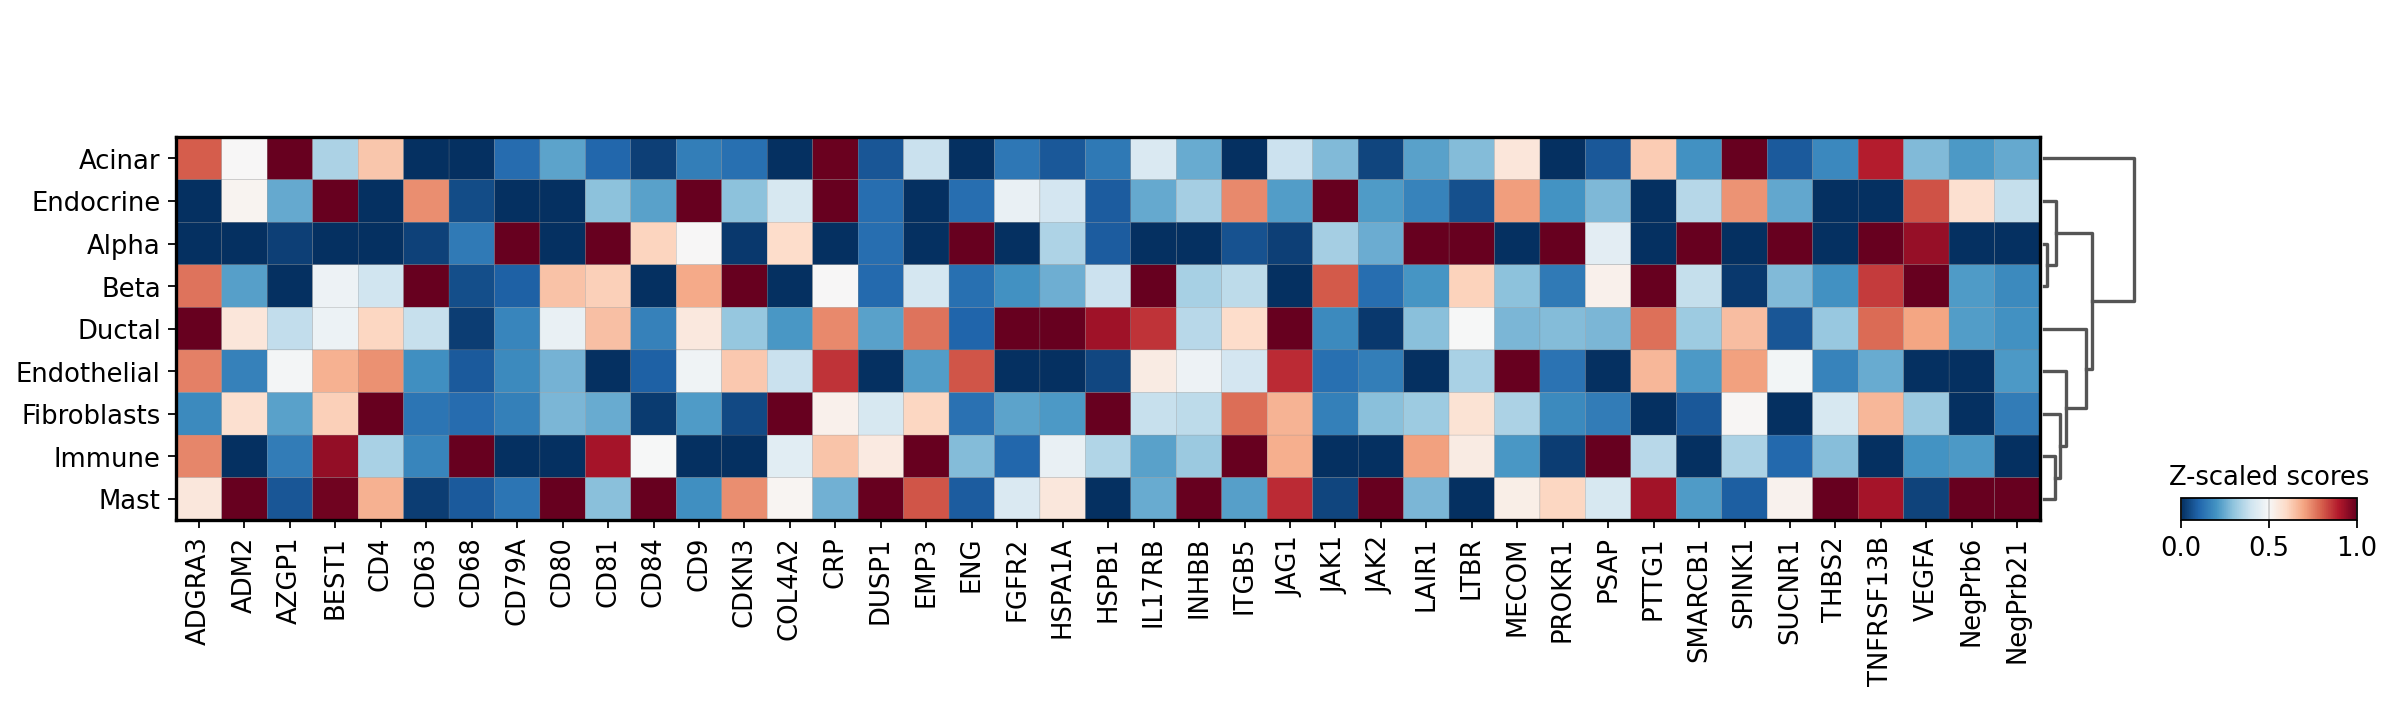

In [57]:
sc.pl.matrixplot(adata, significant_points['symbol'], 'cell_type_coarse', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

In [64]:
adata_ncem = adata[:,np.isin(adata.var_names,significant_points['symbol'])].copy()
adata_ncem

AnnData object with n_obs × n_vars = 4423 × 41
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'cell_type_coarse_colors', 'spatial_neighbors', 'cell_type_coarse_nhood_enrichment', 'cell_type_coarse_interactions', 'cell_type_coarse_ripley_L', 'moranI', 'cell_type_coarse_ligrec', 'ncem

In [68]:
adata_ncem.varm['ncem_fdr_pvals']['index_Mast:neighbor_Alpha']

ADGRA3       7.891279e-04
ADM2         4.900480e-05
AZGP1        2.200083e-05
BEST1        2.163455e-02
CD4          2.878760e-07
CD63         0.000000e+00
CD68         0.000000e+00
CD79A        0.000000e+00
CD80         0.000000e+00
CD81         0.000000e+00
CD84         0.000000e+00
CD9          0.000000e+00
CDKN3        8.016383e-06
COL4A2       2.862283e-03
CRP          2.257738e-03
DUSP1        1.879535e-06
EMP3         3.260053e-07
ENG          2.241494e-04
FGFR2        1.506107e-05
HSPA1A       6.502841e-05
HSPB1        1.099657e-04
IL17RB       3.892967e-02
INHBB        6.081653e-03
ITGB5        0.000000e+00
JAG1         0.000000e+00
JAK1         0.000000e+00
JAK2         0.000000e+00
LAIR1        1.298468e-02
LTBR         2.722002e-02
MECOM        2.046048e-02
PROKR1       1.960015e-05
PSAP         4.815189e-02
PTTG1        2.840808e-02
SMARCB1      3.163901e-02
SPINK1       1.106030e-04
SUCNR1       1.771626e-03
THBS2        2.795928e-08
TNFRSF13B    0.000000e+00
VEGFA       

In [65]:
adata_ncem.X = adata_ncem.varm['ncem_fdr_pvals']
adata_ncem

ValueError: Data matrix has wrong shape (41, 81), need to be (4423, 41).

In [58]:
alpha = 0.0001
np.sum(adata.varm['ncem_fdr_pvals'] < alpha) # and then sort

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


index_Acinar:neighbor_Acinar       21
index_Alpha:neighbor_Acinar        19
index_Beta:neighbor_Acinar         33
index_Ductal:neighbor_Acinar       23
index_Endocrine:neighbor_Acinar    29
                                   ..
index_Endocrine:neighbor_Mast      19
index_Endothelial:neighbor_Mast    32
index_Fibroblasts:neighbor_Mast    21
index_Immune:neighbor_Mast         27
index_Mast:neighbor_Mast           24
Length: 81, dtype: int64

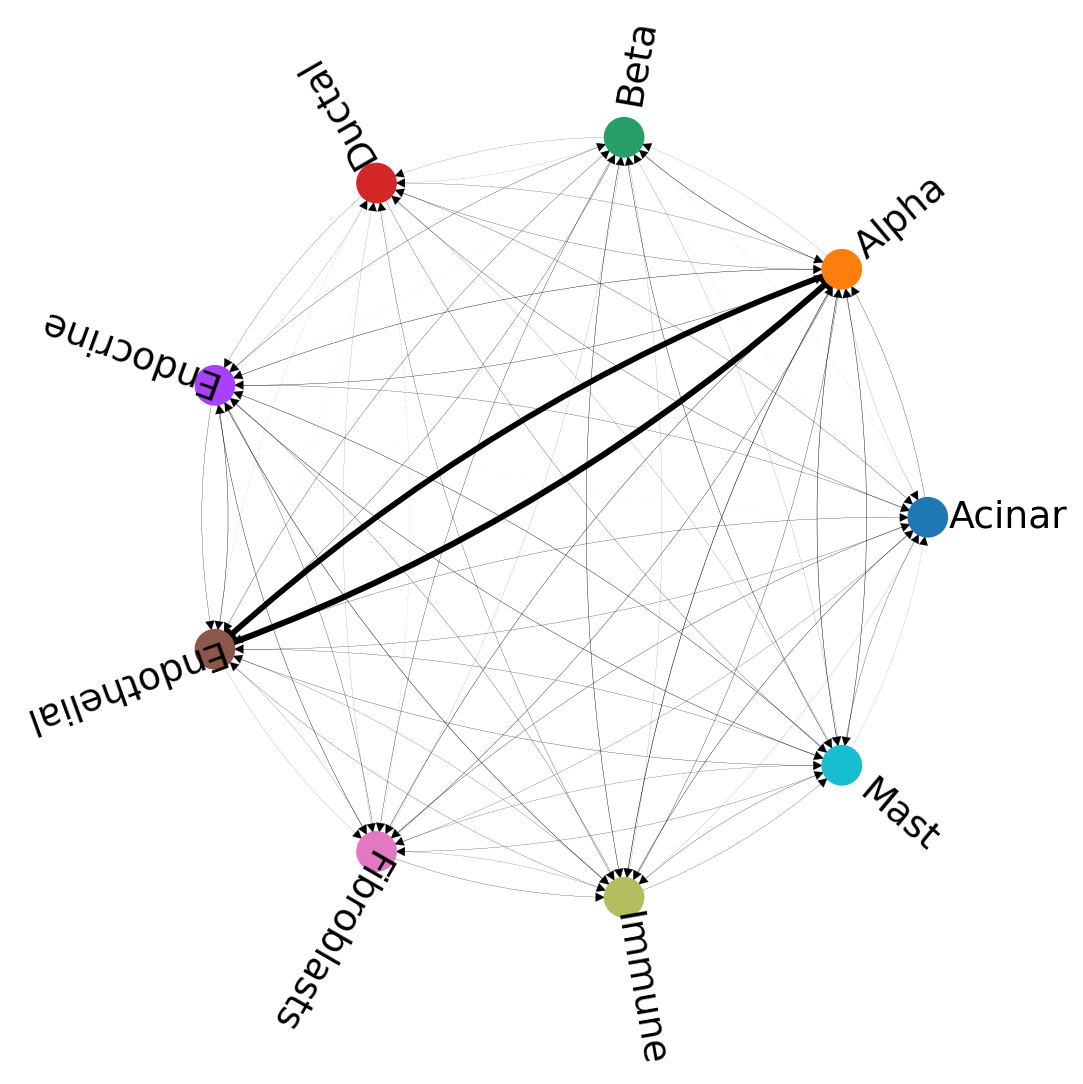

In [62]:
from ncem.pl.type_couplings import circular_rotated_labels
circular_rotated_labels(
    adata, 
    alpha=0.0001, # alpha is threshold when a p-value is considered significant (either 0.01, 0.05, 0.1)
    figsize=(7,7), 
    scale_edge=.1, 
    params_key='ncem_params', 
    pvals_key='ncem_fdr_pvals', 
    edge_type='magnitude', # de_genes ior magnitude
    clip_edges=15 # this value is for plotting reasons --> smaller = more arrows
)

In [ ]:
circular_rotated_labels

In [ ]:
adata.obs.cell_type.cat.categories

In [ ]:
nc.pl.noise_structure(adata,cluster_key='cell_type',figsize=(15,15))

In [ ]:
nc.pl.cluster_freq(adata, cluster_key='cell_type')

In [73]:
adata_s1.uns['cell_type_coarse_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
    '#582f0e'  #mast
]

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


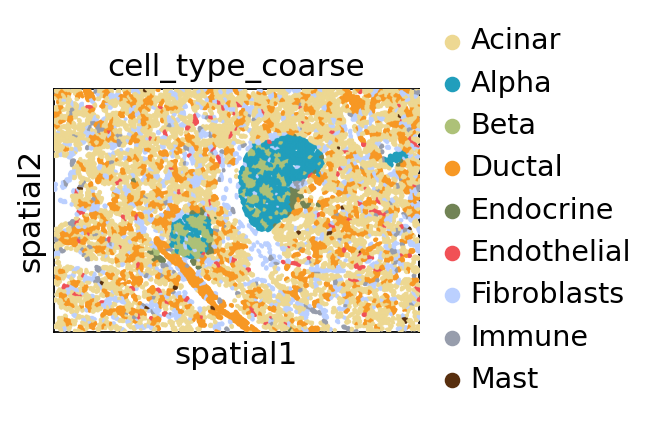

In [76]:
sq.pl.spatial_segment(adata_s1,color='cell_type_coarse',ncols=2,library_id=['12'],
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)#,legend_loc=None)